# Titanic - Machine Learning from Disaster

In [335]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn import datasets
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_curve, roc_auc_score, auc,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, f1_score, average_precision_score,
    classification_report
)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit
# models simples
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# models ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier


Carreguem la base de dades

In [299]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1. EDA (exploratory data analysis) (1 punt)

##### Check basic info about the data set including missing value.

In [300]:
t=train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [301]:
d = train.describe()
d

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Comptar NaNs:

In [302]:
nan_count = train.isnull().sum()
nan_percentage = train.isnull().mean() * 100
print("Número de NaNs por columna:")
print(nan_count)
print("\nPorcentaje de NaNs por columna:")
print(nan_percentage)

Número de NaNs por columna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Porcentaje de NaNs por columna:
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


#### Exploratory analysis and plots

**Plot a bar diagram to check the number of numeric entries**

From the bar diagram, it shows that there are some age entries missing as the number of count for 'Age' is less than the other counts. We can do some impute/transformation of the data to fill-up the missing entries.

Text(0.5, 1.0, 'Bar plot of the count of numeric features')

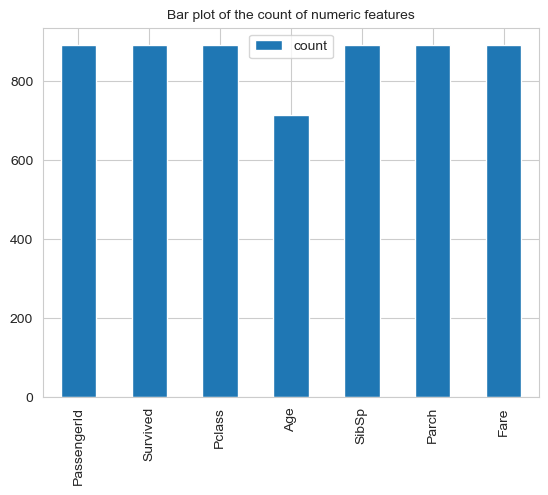

In [303]:
dT=d.T
dT.plot.bar(y='count')
plt.title("Bar plot of the count of numeric features",fontsize=10)

Check the relative size of survived and not-survived.

<Axes: xlabel='Survived', ylabel='count'>

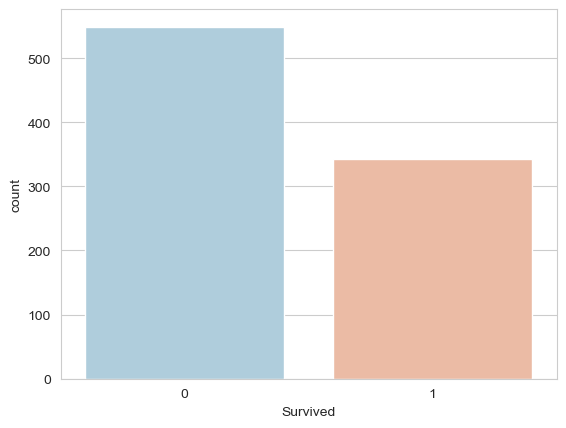

In [304]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=train, palette='RdBu_r')

**Is there a pattern for the survivability based on sex?**

It looks like more female survived than males!

<Axes: xlabel='Survived', ylabel='count'>

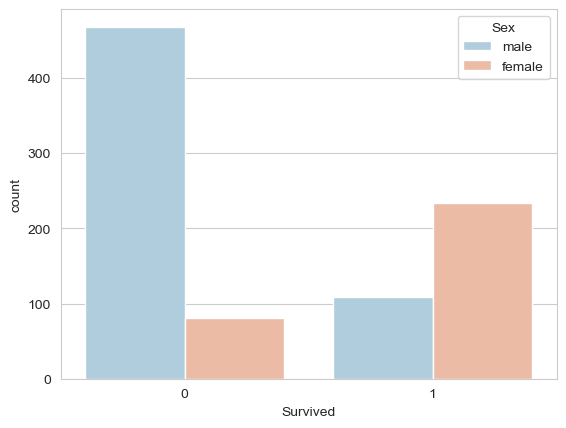

In [305]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

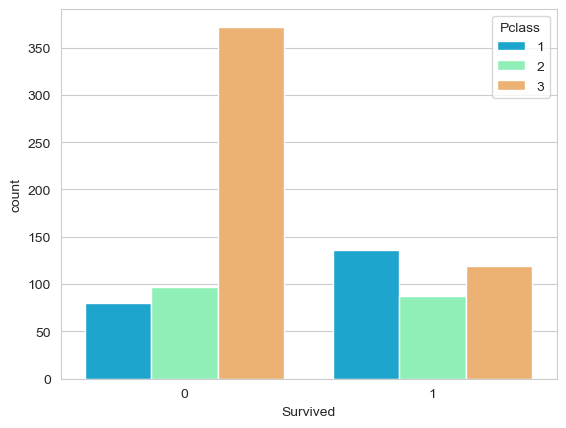

In [306]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

**Following code extracts and plots the fraction of passenger count that survived, by each class**

Text(0.5, 1.0, 'Fraction of passengers survived by class')

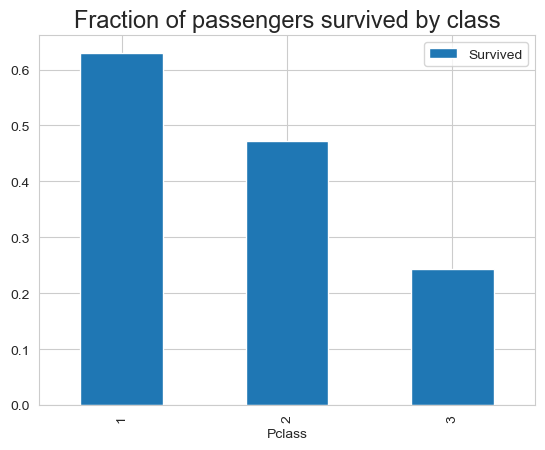

In [307]:
train['Survived'] = train['Survived'].astype(float)
f_class_survived = train.groupby('Pclass')['Survived'].mean()
f_class_survived = pd.DataFrame(f_class_survived)
f_class_survived.plot.bar(y='Survived')
plt.title("Fraction of passengers survived by class",fontsize=17)

**What about any pattern related to having sibling and spouse?**

It looks like there is a weak trend that chance of survibility increased if there were more number of sibling or spouse.

<Axes: xlabel='Survived', ylabel='count'>

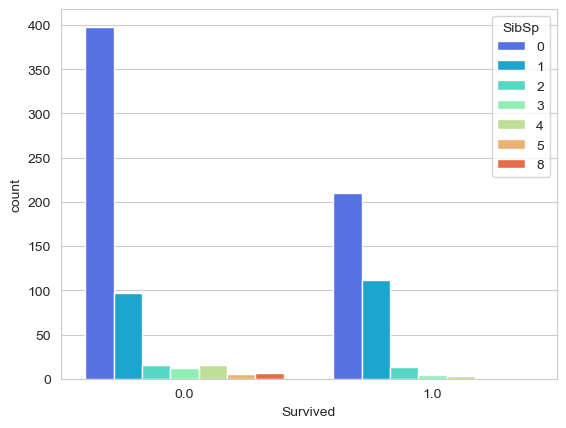

In [308]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='SibSp',data=train,palette='rainbow')

Text(0.5, 0, 'Passenger class')

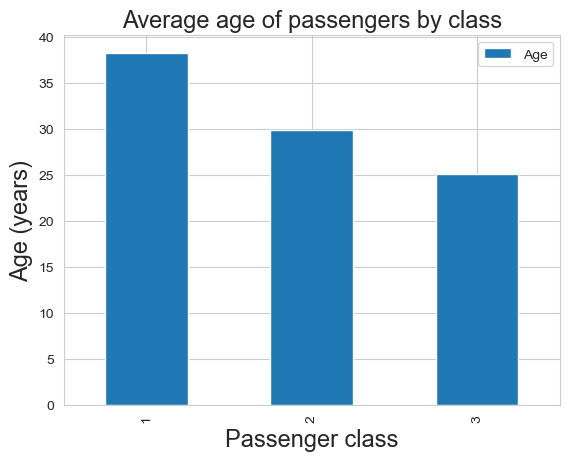

In [309]:
f_class_Age=train.groupby('Pclass')['Age'].mean()
f_class_Age = pd.DataFrame(f_class_Age)
f_class_Age.plot.bar(y='Age')
plt.title("Average age of passengers by class",fontsize=17)
plt.ylabel("Age (years)", fontsize=17)
plt.xlabel("Passenger class", fontsize=17)

### 2. Preprocessing (normalitzation, outlier removal, feature selection..) (2 punts)
* Escala de les dades.
* Impute age (by averaging) - Tractament de NaNs.
* Drop unncessary features
* Convert categorical features to dummy variables - Encodings.

#### Filling Missing Values

Text(0.5, 1.0, 'Bar plot of the count of numeric features')

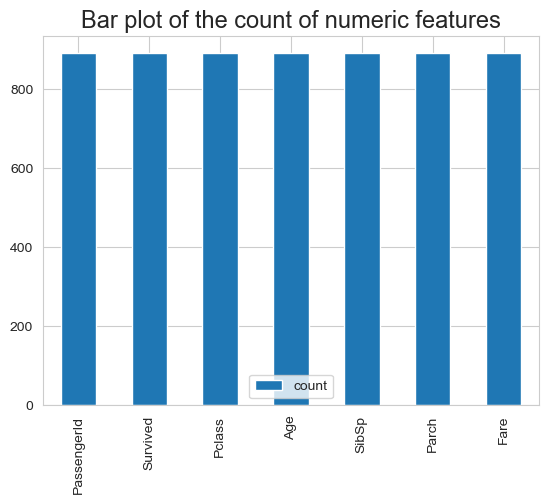

In [310]:
# Crear el imputador, usando 'median' para rellenar los valores faltantes
imputer = SimpleImputer(strategy='mean')

# Ajustar y transformar los datos
train['Age'] = imputer.fit_transform(train['Age'].values.reshape(-1, 1))

# Describir el dataframe y hacer un gráfico de barras
d = train.describe()
dT = d.T
dT.plot.bar(y='count')
plt.title("Bar plot of the count of numeric features",fontsize=17)

#### Exctracting extra features

Before start dropping NaN features I found that we could take some extra features, where some of them are based of features that are about to be droppend due to their high NaN count.

In [311]:
# hasCabin is a binary feature that says if the passanger had a Cabin or not
train['hasCabin'] = train['Cabin'].notna()

# hasFamiliar is a binary feature that says if the passanger had a familiar or not (from SibSp)
train['hasFamiliar'] = train['SibSp'] != 0

Drop unnecessary features like 'PassengerId', 'Name', 'Ticket', 'Cabin' and any other null value

In [312]:
train.drop(['PassengerId','Name','Ticket', 'Cabin'],axis=1,inplace=True)
train.dropna(inplace=True)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,hasCabin,hasFamiliar
0,0.0,3,male,22.0,1,0,7.2500,S,False,True
1,1.0,1,female,38.0,1,0,71.2833,C,True,True
2,1.0,3,female,26.0,0,0,7.9250,S,False,False
3,1.0,1,female,35.0,1,0,53.1000,S,True,True
4,0.0,3,male,35.0,0,0,8.0500,S,False,False


#### Convert categorial feature like 'Sex' and 'Embarked' to dummy variables and then drop the 'Sex' and 'Embarked' columns and concatenate the new dummy variables

**Use pandas 'get_dummies()' function**

In [313]:
sex = pd.get_dummies(train['Sex'])
embark = pd.get_dummies(train['Embarked'])
train.drop(['Sex','Embarked'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,hasCabin,hasFamiliar,female,male,C,Q,S
0,0.0,3,22.0,1,0,7.2500,False,True,False,True,False,False,True
1,1.0,1,38.0,1,0,71.2833,True,True,True,False,True,False,False
2,1.0,3,26.0,0,0,7.9250,False,False,True,False,False,False,True
3,1.0,1,35.0,1,0,53.1000,True,True,True,False,False,False,True
4,0.0,3,35.0,0,0,8.0500,False,False,False,True,False,False,True


#### Escala de dades.

Primer mirem com queden les nostres dades.

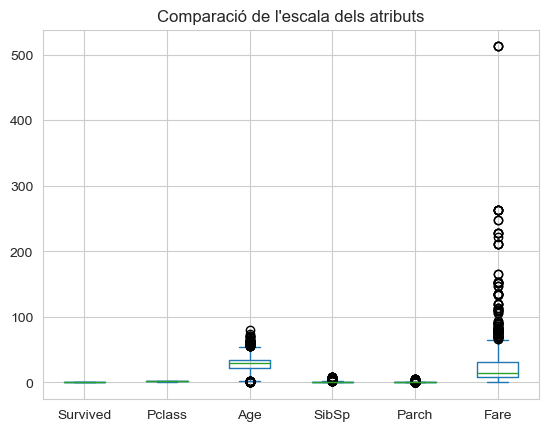

In [314]:
train.plot(kind='box')
plt.title('Comparació de l\'escala dels atributs')
plt.show()

Ara normalitzem:

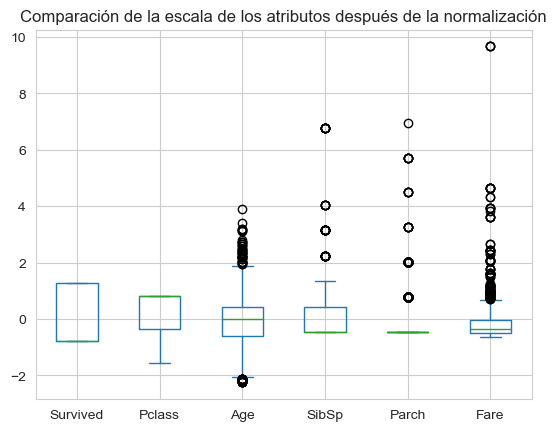

In [315]:
X = train.drop('Survived', axis=1).to_numpy()  # Característiques
y = train['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

num_cols = train.select_dtypes(include=['float64', 'int64']).columns

train[num_cols] = scaler.fit_transform(train[num_cols])

train[num_cols].plot(kind='box')
plt.title('Comparación de la escala de los atributos después de la normalización')
plt.show()

#### Polinomial features

As extra features we can add extra features which can help de model find any quadratic, cubic or basically polynomic correlation between certain features and the label, in this case we find usefull to use Numbered features such as Age and Fare.

In [316]:
from sklearn.preprocessing import PolynomialFeatures

def create_polynomial_features(data, columns, degree):
    # Copy the DataFrame
    data_copy = data.copy()

    poly = PolynomialFeatures(degree=degree, include_bias=False)

    for c in columns:
        # Select the specific column to apply polynomial features
        selected_data = data_copy[[c]]
        poly_data = poly.fit_transform(selected_data)

        # Create column names for the new polynomial features
        poly_column_names = [f"{c}_poly_{i}" for i in range(poly_data.shape[1])]
        print(poly_column_names)

        # Add the polynomial features to the DataFrame
        data_copy[poly_column_names] = poly_data

    # Drop the original columns that were transformed
    data_copy = data_copy.drop(columns=columns)

    return data_copy

train_sq = create_polynomial_features(train, ['Age', 'Fare'], 2)
train_sq.head()


['Age_poly_0', 'Age_poly_1']
['Fare_poly_0', 'Fare_poly_1']


,Survived,Pclass,SibSp,Parch,hasCabin,hasFamiliar,female,male,C,Q,S,Age_poly_0,Age_poly_1,Fare_poly_0,Fare_poly_1
0,-0.786961,0.825209,0.431350,-0.474326,False,True,False,True,False,False,True,-0.590495,0.348684,-0.500240,0.250240
1,1.270711,-1.572211,0.431350,-0.474326,True,True,True,False,True,False,False,0.643971,0.414699,0.788947,0.622437
2,1.270711,0.825209,-0.475199,-0.474326,False,False,True,False,False,False,True,-0.281878,0.079455,-0.486650,0.236828
3,1.270711,-1.572211,0.431350,-0.474326,True,True,True,False,False,False,True,0.412509,0.170163,0.422861,0.178812
4,-0.786961,0.825209,-0.475199,-0.474326,False,False,False,True,False,False,True,0.412509,0.170163,-0.484133,0.234385


#### Preprocessing Feature Selection

##### Finding multicolineality:

In [317]:
correlation_matrix = train.corr()

# Trobar correlacions altes
highly_correlated = (correlation_matrix > 0.8) & (correlation_matrix < 1.0)
print(highly_correlated)

             Survived  Pclass    Age  SibSp  Parch   Fare  hasCabin  \
Survived        False   False  False  False  False  False     False   
Pclass          False   False  False  False  False  False     False   
Age             False   False  False  False  False  False     False   
SibSp           False   False  False  False  False  False     False   
Parch           False   False  False  False  False  False     False   
Fare            False   False  False  False  False  False     False   
hasCabin        False   False  False  False  False  False     False   
hasFamiliar     False   False  False  False  False  False     False   
female          False   False  False  False  False  False     False   
male            False   False  False  False  False  False     False   
C               False   False  False  False  False  False     False   
Q               False   False  False  False  False  False     False   
S               False   False  False  False  False  False     False   

     

##### Reducing high dimensions:

To detect high dimensions, we calculate the correlation matrix between the variables, computed in the previous cell. Variables with low or close-to-zero correlations can be considered high dimensions because they contain little relevant information. One of the indicators of the height of dimensions is the eigenspace of the correlation matrix.

In [318]:
# Càlcul dels autovectors i autovectors
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)

# Trobar les dimensions amb baixes contribucions
explained_variance_ratio = eigenvalues / sum(eigenvalues)
print([[var, x] for var, x in zip(explained_variance_ratio, train.columns)])

[[0.24950962122481044, 'Survived'], [0.17895339135029584, 'Pclass'], [0.1438795197657002, 'Age'], [0.12169812749183836, 'SibSp'], [0.07813462095877917, 'Parch'], [0.05980555491694668, 'Fare'], [0.0550988877428793, 'hasCabin'], [0.03902135795478292, 'hasFamiliar'], [0.034421267017523786, 'female'], [0.021349027616221747, 'male'], [0.018128623960221555, 'C'], [9.851917978394759e-18, 'Q'], [1.0922891290620139e-16, 'S']]


Here, as we can see, we obtain low correlation in attributes except for Pclass, Age, and SibSp. We will create a new dataframe with these variables that have a higher correlation.

In [319]:
cutted_train = train[['Pclass', 'Age', 'SibSp']]

X = train.drop('Survived', axis=1)  # Característiques
y = train['Survived']

X_train_cutted, X_test_cutted, y_train_cutted, y_test_cutted = train_test_split(X , y, test_size=0.2, random_state=42)
scaler = StandardScaler()

X_train_cutted = scaler.fit_transform(X_train_cutted)
X_test_cutted = scaler.transform(X_test_cutted)

##### Aplicant PCA en tots les datasets

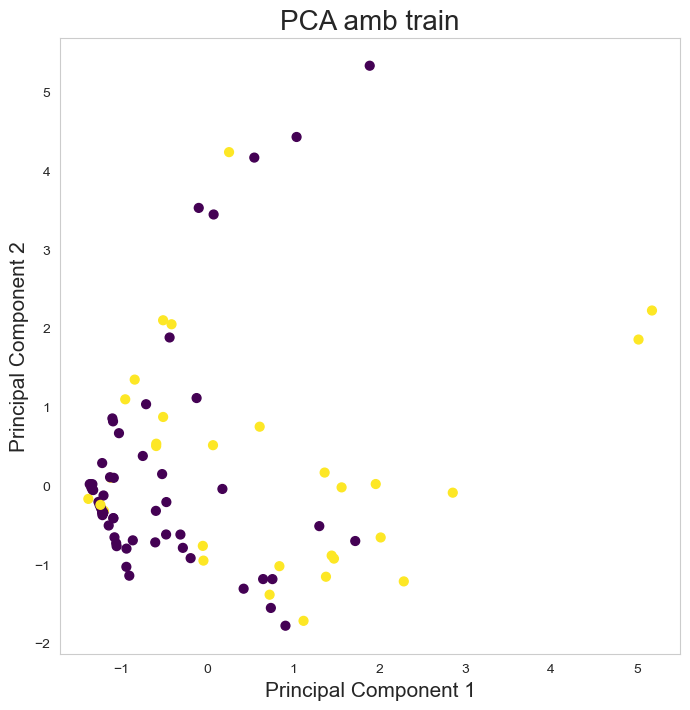

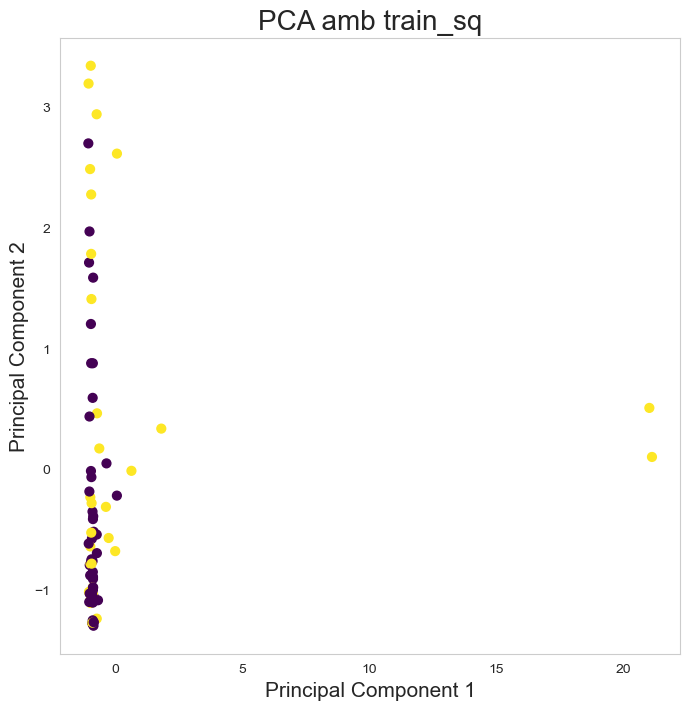

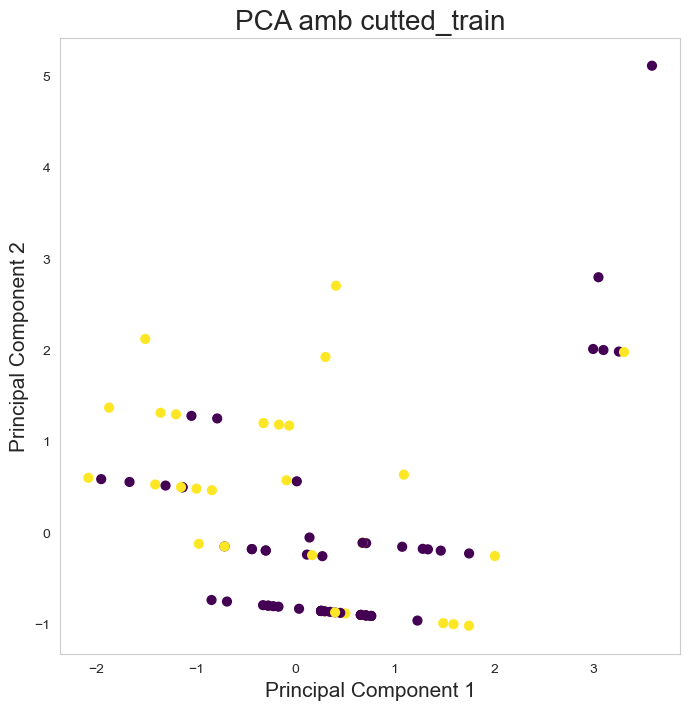

In [320]:
from sklearn.decomposition import PCA

def plot_PCA(x, y, components=2, title='2 component PCA'):
    pca = PCA(n_components=components)
    
    principalComponents = pca.fit_transform(x)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    
    ax.scatter(principalComponents[::10,0], principalComponents[::10,1],c = y[::10], s = 40, cmap='viridis')
    ax.grid()


plot_PCA(train.drop(columns=['Survived']), train['Survived'], title='PCA amb train')
plot_PCA(train_sq.drop(columns=['Survived']), train['Survived'], title='PCA amb train_sq')
plot_PCA(cutted_train, train['Survived'], title='PCA amb cutted_train')

As we can see, with PCA, we obtain principal components with fairly scattered points in the normal training dataset.

Meanwhile, with PCA squared, we no longer obtain normalized data because we have quadratic attributes that exaggerate the values we previously normalized, creating extreme cases like the last two that are around 60000.

Finally, with the dataset trimmed to those with higher linear correlation, we obtain principal components that even seem to have some correlation, although they are still scattered between one class and another.

### 3. Metric selection (1.5 punts)

#### Model de proba

We'll use a super simple logistic regression model to have 

Funcion para mostrar el performance del modelo.

In [321]:
def show_performance(x, y, model, title='confusion matrix', average='binary', figsize=(5, 5)):
    predictions = model.predict(x)
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, average=average)
    rec = recall_score(y, predictions, average=average)
    f1 = f1_score(y, predictions, average=average)

    conf_mat = confusion_matrix(y, predictions)
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    print(f'Accuracy:{acc}')
    print(f'Precision:{prec}')
    print(f'Recall:{rec}')
    print(f'F1-score:{f1}')
    
    disp=ConfusionMatrixDisplay(conf_mat)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

Funcion para mostrar la curva ROC.

In [322]:
def generate_roc(X_test, y_test, model):
    # generate a no skill prediction (majority class)
    ns_probs = [1 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    # summarize scores
    print('Classificador sense capacitat predictiva: ROC AUC=%.3f' % (ns_auc))
    print('El nostre model: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sense capacitat predictiva')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Nostre')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

Funcion para mostrar la curva Precision/Recall.

In [323]:
def generate_PR(X_test, y_test, model):
     # generate a no skill prediction (majority class)
    ns_probs = [1 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    lr_auc = auc(lr_recall, lr_precision)
    # summarize score
    print('El nostre model té una auc=%.3f' % (lr_auc))
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sense capacitat predictiva')
    plt.plot(lr_recall, lr_precision, marker='.', label='Nostre')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

Classificador sense capacitat predictiva: ROC AUC=0.500
El nostre model: ROC AUC=0.811


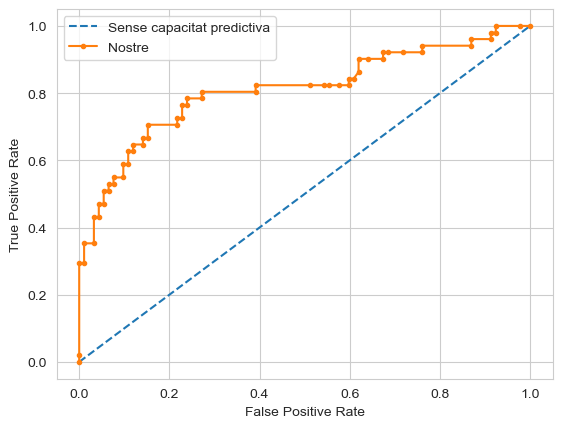

El nostre model té una auc=0.778


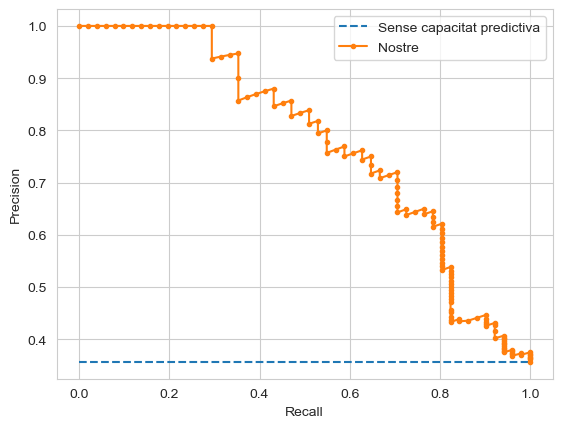

Accuracy:0.7902097902097902
Precision:0.7560975609756098
Recall:0.6078431372549019
F1-score:0.6739130434782609


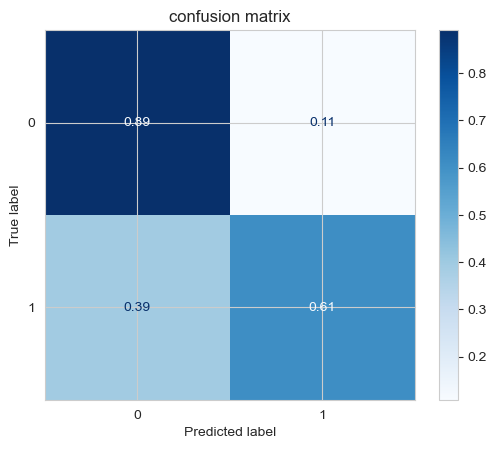

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.85        92
         1.0       0.76      0.61      0.67        51

    accuracy                           0.79       143
   macro avg       0.78      0.75      0.76       143
weighted avg       0.79      0.79      0.78       143



In [324]:
X_train_MS, X_test_MS, y_train_MS, y_test_MS = train_test_split(X_train , y_train, test_size=0.2, random_state=42)

# Create and fit a logistic regression model
model = LogisticRegression()
model.fit(X_train_MS, y_train_MS)

generate_roc(X_test_MS, y_test_MS, model)
generate_PR(X_test_MS, y_test_MS, model)

show_performance(X_test_MS, y_test_MS, model)

# Make predictions on the test set
y_pred_MS = model.predict(X_test_MS)

# Gener_MSate a classification report
report = classification_report(y_test_MS, y_pred_MS)

print(report)

### 4. Model Selection amb validacio creuada (4 punts)

KNN:

Grid: {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'p': [1, 2], 'weights': ['uniform', 'distance']}
Best parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best F1 found: 0.77956
Accuracy:0.7640449438202247
Precision:0.684931506849315
Recall:0.7246376811594203
F1-score:0.704225352112676


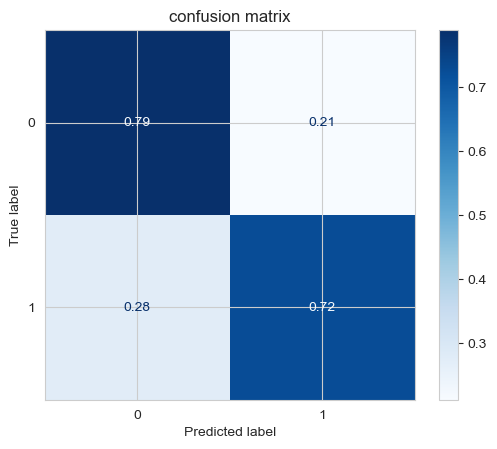

In [340]:
param_grid = dict(n_neighbors=list(range(5, 20)), p=[1,2], weights=['uniform', 'distance'] )
print(f'Grid: {param_grid}')

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='f1')
grid.fit(X_train, y_train)
grid.cv_results_.keys()

# Examine the best model
# Dictionary containing the parameters used to generate that score
print(f'Best parameters: {grid.best_params_}')
# Single best score achieved across all params (k)
print(f'Best F1 found: {round(grid.best_score_, 5)}')
show_performance(X_test, y_test, grid.best_estimator_)


Support Vector Machines (SVM):

In [ ]:
param_grid = dict(tol=[1e-2, 1e-3, 1e-4], 
                  class_weight=[None, 'balanced'])
print(f'Grid: {param_grid}')

svc = SVC(random_state=0, kernel='linear', probability=True)
grid = GridSearchCV(svc, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)
grid.cv_results_.keys()

# Examine the best model
best_svc = grid.best_estimator_
# Dictionary containing the parameters used to generate that score
print(f'Best parameters: {grid.best_params_}')
# Single best score achieved across all params (k)
print(f'Best F1 found: {round(grid.best_score_, 5)}')

In [ ]:
show_metrics(x_test, y_test, best_svc, average='binary')
show_confusion_matrix(x_test, y_test, best_svc, 'Train set confusion matrix')
show_roc_curve(x_test, y_test, best_svc)

AdaBoost DecisionTree:

In [ ]:
param_grid = dict(n_estimators=list(range(100, 201, 50)), 
                  base_estimator__max_depth=[1, 2, 3], 
                  base_estimator__criterion=['gini', 'entropy'])

print(f'Grid: {param_grid}')

ada_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=0))
grid = GridSearchCV(ada_boost, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(x_train, y_train)
grid.cv_results_.keys()

# Examine the best model
best_ada_trees = grid.best_estimator_
# Dictionary containing the parameters used to generate that score
print(f'Best parameters: {grid.best_params_}')
# Single best score achieved across all params (k)
print(f'Best F1 found: {round(grid.best_score_, 5)}')

In [ ]:
show_metrics(x_test, y_test, best_ada_trees, average='binary')
show_confusion_matrix(x_test, y_test, best_ada_trees, 'Train set confusion matrix')
show_roc_curve(x_test, y_test, best_ada_trees)

RandomForest:

In [ ]:
param_grid = dict(n_estimators=list(range(75, 151, 25)), 
                  max_depth=list(range(4, 8, 1)), 
                  criterion=['gini', 'entropy'],
                  max_features=['sqrt', 'log2'])
print(f'Grid: {param_grid}')

rf = RandomForestClassifier(random_state=0)
grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(x_train, y_train)
grid.cv_results_.keys()

# Examine the best model
best_rf = grid.best_estimator_
# Dictionary containing the parameters used to generate that score
print(f'Best parameters: {grid.best_params_}')
# Single best score achieved across all params (k)
print(f'Best F1 found: {round(grid.best_score_, 5)}')

In [ ]:
show_metrics(x_test, y_test, best_rf, average='binary')
show_confusion_matrix(x_test, y_test, best_rf, 'Train set confusion matrix')
show_roc_curve(x_test, y_test, best_rf)

### 5.Analisi Final (1.5 punt)
